#  따릉이

* Data : 서울 공유 자전거
* 문제 : 2시간 후의 수요를 예측하고자 함함.

* **공유 자전거 운영팀**에서는 공유자전거가 부족한 지역과 남는 지역에 대해서 판단하기 원합니다.
* 2시간 전에 **공유자전거 수요량**을 예측할 수 있다면, 이동시켜서 남거나 부족한 문제를 해결할수 있다고 합니다.

![](https://cf.creatrip.com/original/blog/7376/kw69f1cy6ehvmmu9enuubth31zw5i7a7.jpg?d=1200&q=80&f=webp)

## 1.환경준비

### (1) 라이브러리 로딩

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense
from keras.backend import clear_session
from keras.optimizers import Adam

* 함수 만들기

In [37]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.figure(figsize=(10,6))
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

### (2) 데이터로딩

In [38]:
path = 'https://raw.githubusercontent.com/DA4BAM/dataset/master/SeoulBikeData2.csv'
data = pd.read_csv(path)
data['DateTime'] = pd.to_datetime(data['DateTime'])
data.drop(['Visibility','Solar'], axis = 1, inplace = True)
data.head(10)

,DateTime,Count,Temperature,Humidity,WindSpeed,Rainfall,Snowfall,Seasons,Holiday,FuncDay
0,2017-12-01 00:00:00,254,-5.2,37,2.2,0.0,0.0,Winter,No Holiday,Yes
1,2017-12-01 01:00:00,204,-5.5,38,0.8,0.0,0.0,Winter,No Holiday,Yes
2,2017-12-01 02:00:00,173,-6.0,39,1.0,0.0,0.0,Winter,No Holiday,Yes
3,2017-12-01 03:00:00,107,-6.2,40,0.9,0.0,0.0,Winter,No Holiday,Yes
4,2017-12-01 04:00:00,78,-6.0,36,2.3,0.0,0.0,Winter,No Holiday,Yes
5,2017-12-01 05:00:00,100,-6.4,37,1.5,0.0,0.0,Winter,No Holiday,Yes
6,2017-12-01 06:00:00,181,-6.6,35,1.3,0.0,0.0,Winter,No Holiday,Yes
7,2017-12-01 07:00:00,460,-7.4,38,0.9,0.0,0.0,Winter,No Holiday,Yes
8,2017-12-01 08:00:00,930,-7.6,37,1.1,0.0,0.0,Winter,No Holiday,Yes
9,2017-12-01 09:00:00,490,-6.5,27,0.5,0.0,0.0,Winter,No Holiday,Yes


**변수설명**  

* DateTime : year-month-day hh:mi:ss
* Count : 시간대별 수요량
* Temperature : 온도(섭씨)
* Humidity : 습도(%)
* WindSpeed : 풍속(m/s)
* Rainfall - mm
* Snowfall - cm
* Seasons - Winter, Spring, Summer, Autumn
* Holiday - Holiday / No holiday
* FuncDay - Yes / No


In [39]:
# 데이터 기간은 다음과 같습니다.
data.DateTime.min(), data.DateTime.max()

(Timestamp('2017-12-01 00:00:00'), Timestamp('2018-11-30 23:00:00'))

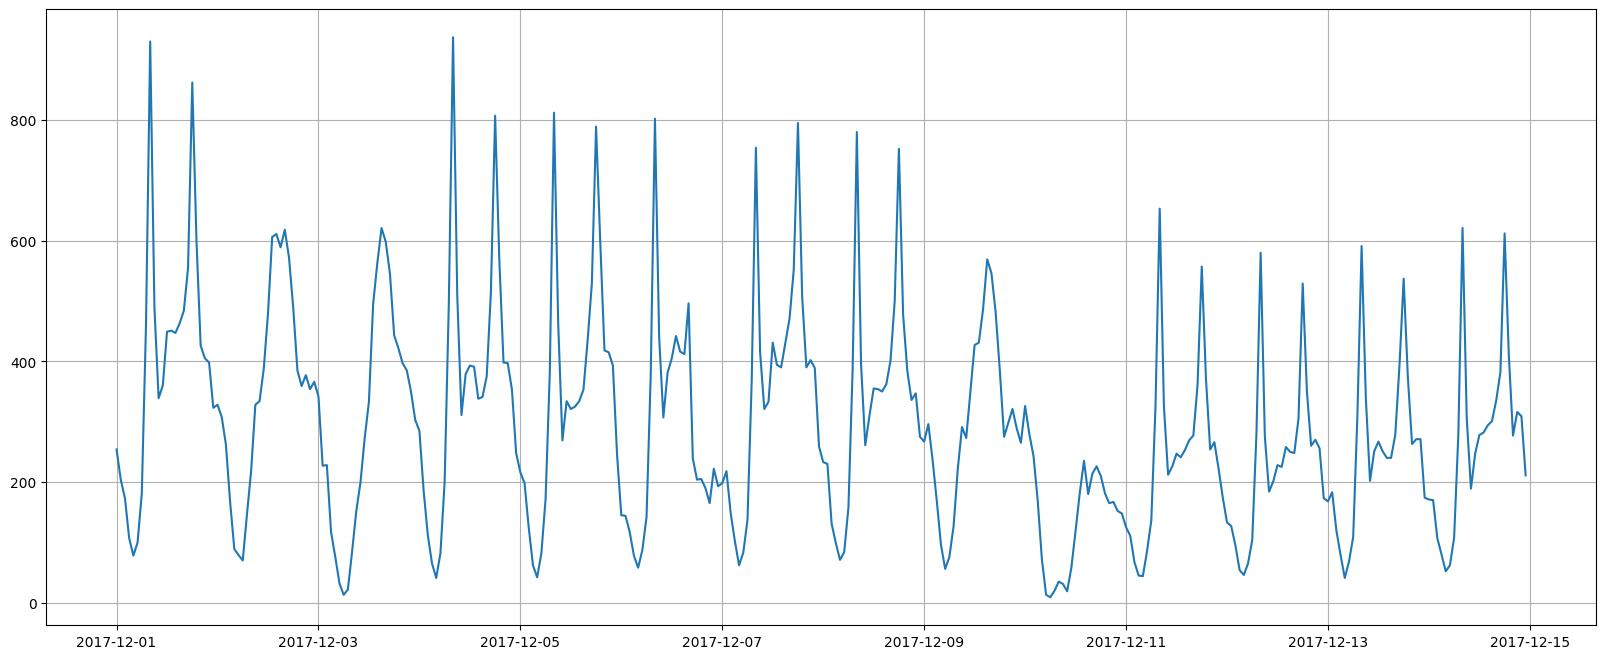

In [40]:
# 14일 동안의 수요량을 살펴 봅시다.
temp = data[:24*14]
plt.figure(figsize = (20,8))
plt.plot('DateTime', 'Count', data = temp)
plt.grid()
plt.show()

## 2.데이터 준비

### (1) y 만들기
* 2시간 이후의 수요량을 예측해야 합니다.

In [41]:
data['y'] = data['Count'].shift(-2)
data.head()

,DateTime,Count,Temperature,Humidity,WindSpeed,Rainfall,Snowfall,Seasons,Holiday,FuncDay,y
0,2017-12-01 00:00:00,254,-5.2,37,2.2,0.0,0.0,Winter,No Holiday,Yes,173.0
1,2017-12-01 01:00:00,204,-5.5,38,0.8,0.0,0.0,Winter,No Holiday,Yes,107.0
2,2017-12-01 02:00:00,173,-6.0,39,1.0,0.0,0.0,Winter,No Holiday,Yes,78.0
3,2017-12-01 03:00:00,107,-6.2,40,0.9,0.0,0.0,Winter,No Holiday,Yes,100.0
4,2017-12-01 04:00:00,78,-6.0,36,2.3,0.0,0.0,Winter,No Holiday,Yes,181.0


In [42]:
# 2칸을 앞당겼기 때문에 하위 2행의 y값에 NaN이 표시되어 있습니다.
data.tail()

,DateTime,Count,Temperature,Humidity,WindSpeed,Rainfall,Snowfall,Seasons,Holiday,FuncDay,y
8755,2018-11-30 19:00:00,1003,4.2,34,2.6,0.0,0.0,Autumn,No Holiday,Yes,694.0
8756,2018-11-30 20:00:00,764,3.4,37,2.3,0.0,0.0,Autumn,No Holiday,Yes,712.0
8757,2018-11-30 21:00:00,694,2.6,39,0.3,0.0,0.0,Autumn,No Holiday,Yes,584.0
8758,2018-11-30 22:00:00,712,2.1,41,1.0,0.0,0.0,Autumn,No Holiday,Yes,NaN
8759,2018-11-30 23:00:00,584,1.9,43,1.3,0.0,0.0,Autumn,No Holiday,Yes,NaN


In [43]:
# 하위 2행은 삭제합니다.
# 하위 2행 제외하고 다시 붓기
data = data.iloc[:-2]

### (2) 데이터 정리
* 불필요한 변수 제거 : DateTime
* x, y  나누기

In [44]:
target = 'y'
x = data.drop(target, axis = 1)
y = data.loc[:, target]

In [45]:
# 날짜 데이터 제거
x.drop('DateTime', axis = 1, inplace = True)
x.head()

,Count,Temperature,Humidity,WindSpeed,Rainfall,Snowfall,Seasons,Holiday,FuncDay
0,254,-5.2,37,2.2,0.0,0.0,Winter,No Holiday,Yes
1,204,-5.5,38,0.8,0.0,0.0,Winter,No Holiday,Yes
2,173,-6.0,39,1.0,0.0,0.0,Winter,No Holiday,Yes
3,107,-6.2,40,0.9,0.0,0.0,Winter,No Holiday,Yes
4,78,-6.0,36,2.3,0.0,0.0,Winter,No Holiday,Yes


### (3) NaN 조치

### (4) 가변수화

In [46]:
cat_cols = ['Seasons','Holiday','FuncDay']
x = pd.get_dummies(x, columns = cat_cols, drop_first = True)

### (5) 데이터분할 : train : val

* 시계열 데이터이므로 시간의 흐름에 맞게 분할
    * 뒤에서 30일 : validaiton
    * 나머지 : train
    * 30일 : 시간단위 데이터이므로 24 * 30
* train_test_split : shuffle(뒤섞기) 옵션을 False로 하면 저장된 순서대로 자름


In [47]:
i = 30 * 24
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = i, shuffle = False)

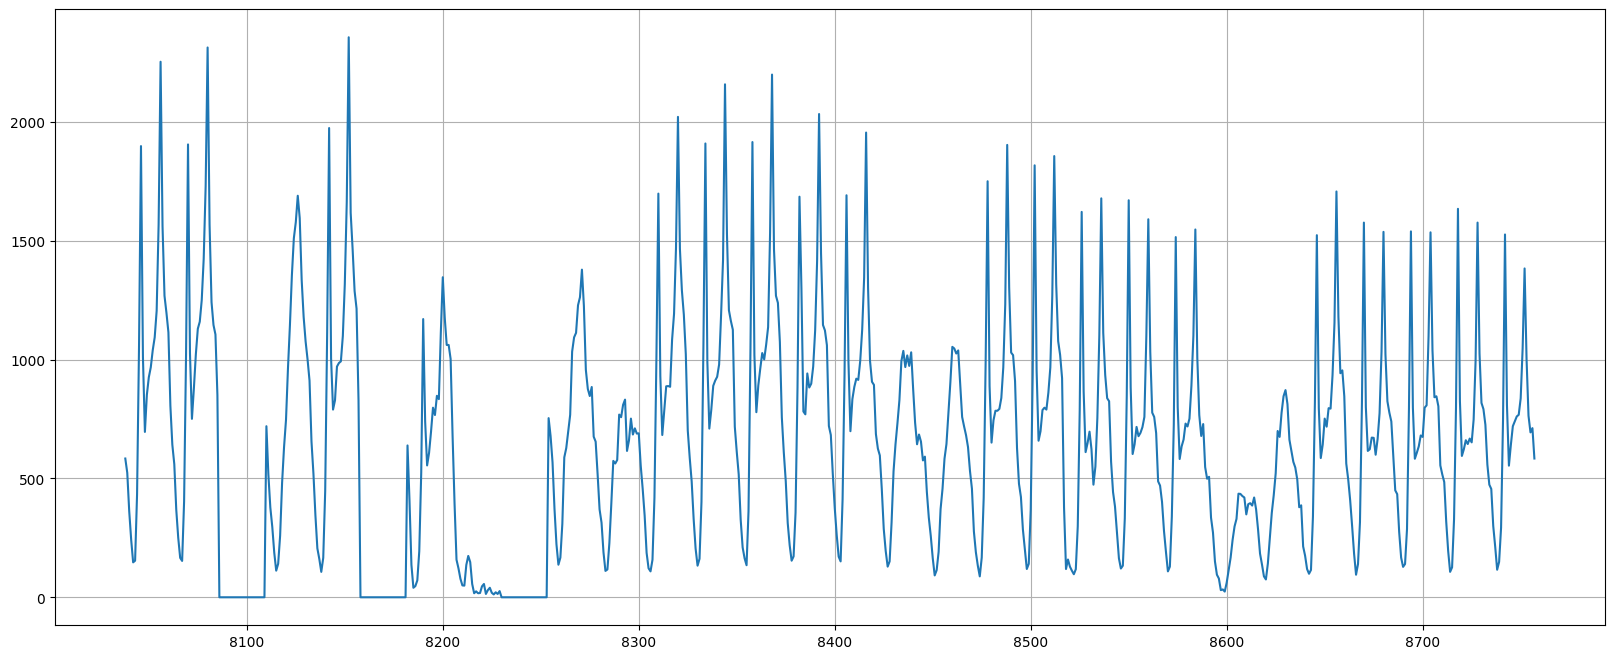

In [48]:
plt.figure(figsize = (20,8))
plt.plot(y_val)
plt.grid()
plt.show()

### (6) Scaling

In [49]:
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)

## 3.모델링

* 히든레이어를 추가한 모델 두 개 이상을 생성한 후
* 성능을 비교하시오.
* 성능을 높이기 위해서 조절할 것들
    * 히든레이어 수
    * 히든레이어 노드수
    * epochs 수
    * learning_rate : 0.1 ~ 0.0001 사이에서 조정(예 Adam(learning_rate = 0.01))


### (1) 모델1

In [50]:
nfeatures = x_train.shape[1]
nfeatures

11

In [51]:
# 메모리 최적화
clear_session()

# Sequential 타입 모델 선언
model = Sequential([Dense(11, input_shape=(nfeatures,), activation='relu'),
                    Dense(4, activation='relu'),
                    Dense(1)])

# 모델 요약
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 11)                132       
                                                                 
 dense_1 (Dense)             (None, 4)                 48        
                                                                 
 dense_2 (Dense)             (None, 1)                 5         
                                                                 
Total params: 185 (740.00 Byte)
Trainable params: 185 (740.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [52]:
# 모델 컴파일 및 학습
model.compile(optimizer=Adam(0.5), loss='mse')

hist = model.fit(x_train, y_train, epochs=70, validation_split=.2).history

Epoch 1/70
201/201 [==============================] - 3s 7ms/step - loss: 192893.6094 - val_loss: 318081.0938
Epoch 2/70
201/201 [==============================] - 2s 10ms/step - loss: 144550.6562 - val_loss: 212053.2344
Epoch 3/70
201/201 [==============================] - 2s 9ms/step - loss: 139899.8750 - val_loss: 243919.1406
Epoch 4/70
201/201 [==============================] - 2s 8ms/step - loss: 139843.8438 - val_loss: 256386.4688
Epoch 5/70
201/201 [==============================] - 1s 5ms/step - loss: 141386.5469 - val_loss: 203410.1875
Epoch 6/70
201/201 [==============================] - 1s 5ms/step - loss: 136433.8594 - val_loss: 231630.4688
Epoch 7/70
201/201 [==============================] - 2s 8ms/step - loss: 132810.2656 - val_loss: 199955.7812
Epoch 8/70
201/201 [==============================] - 1s 5ms/step - loss: 143127.3750 - val_loss: 196940.2812
Epoch 9/70
201/201 [==============================] - 1s 6ms/step - loss: 130110.5234 - val_loss: 196591.4375
Epoch 10/

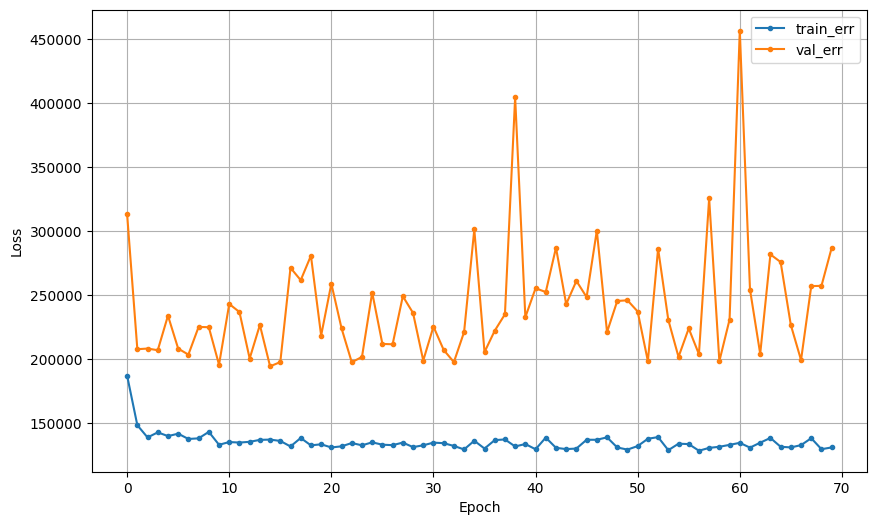

In [ ]:
dl_history_plot(hist)

In [53]:
pred = model.predict(x_val)

print(f'RMSE : {mean_squared_error(y_val, pred, squared=False)}')
print(f'MAE : {mean_absolute_error(y_val, pred)}')
print(f'MAPE : {mean_absolute_percentage_error(y_val, pred)}')

23/23 [==============================] - 0s 5ms/step
RMSE : 355.05074135324713
MAE : 267.27808149125843
MAPE : 8.353256019198534e+16


### (2) 모델2

In [54]:
# 메모리 최적화
clear_session()

# Sequential 타입 모델 선언
model2 = Sequential([Dense(20, input_shape=(nfeatures,), activation='relu'),
                    Dense(6, activation='relu'),
                    Dense(1)])

# 모델 요약
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                240       
                                                                 
 dense_1 (Dense)             (None, 6)                 126       
                                                                 
 dense_2 (Dense)             (None, 1)                 7         
                                                                 
Total params: 373 (1.46 KB)
Trainable params: 373 (1.46 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [55]:
# 모델 컴파일 및 학습
model2.compile(optimizer=Adam(0.1), loss='mse')

hist2 = model2.fit(x_train, y_train, epochs=30, validation_split=.2).history

Epoch 1/30
201/201 [==============================] - 1s 3ms/step - loss: 225675.5469 - val_loss: 318562.2188
Epoch 2/30
201/201 [==============================] - 0s 2ms/step - loss: 136766.3906 - val_loss: 248959.1094
Epoch 3/30
201/201 [==============================] - 1s 3ms/step - loss: 136443.6094 - val_loss: 216686.5625
Epoch 4/30
201/201 [==============================] - 0s 2ms/step - loss: 133679.2812 - val_loss: 218217.5156
Epoch 5/30
201/201 [==============================] - 1s 3ms/step - loss: 132766.9375 - val_loss: 235917.8281
Epoch 6/30
201/201 [==============================] - 1s 3ms/step - loss: 130609.9688 - val_loss: 247106.5312
Epoch 7/30
201/201 [==============================] - 1s 4ms/step - loss: 132828.5625 - val_loss: 213385.5781
Epoch 8/30
201/201 [==============================] - 1s 4ms/step - loss: 131997.1562 - val_loss: 225609.2188
Epoch 9/30
201/201 [==============================] - 1s 3ms/step - loss: 131111.1562 - val_loss: 195641.4375
Epoch 10/3

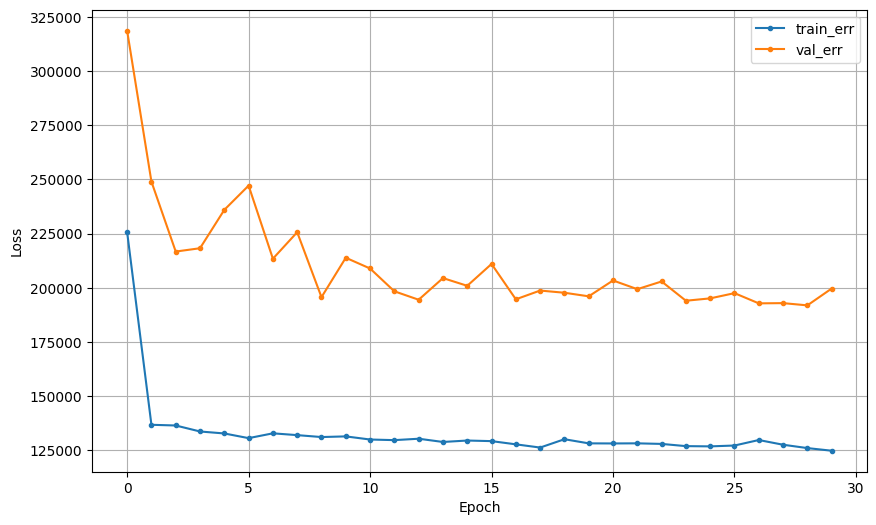

In [56]:
dl_history_plot(hist2)

In [57]:
pred2 = model2.predict(x_val)

print(f'RMSE : {mean_squared_error(y_val, pred2, squared=False)}')
print(f'MAE : {mean_absolute_error(y_val, pred2)}')
print(f'MAPE : {mean_absolute_percentage_error(y_val, pred2)}')

23/23 [==============================] - 0s 1ms/step
RMSE : 344.16810324467804
MAE : 253.26056621604496
MAPE : 7.566370306608187e+16
